In [1]:
import tables
import numpy as np
from random import shuffle
from math import ceil
import matplotlib.pyplot as plt

In [2]:
hdf5_path = 'raw.hdf5'  # Path where dataset.hdf5 file is stored
subtract_mean = True
batch_size = 50
nb_class = 8

In [3]:
hdf5_file = tables.open_file(hdf5_path, mode='r')
# subtract the training mean
if subtract_mean:
    mm = hdf5_file.root.train_mean[0]
    mm = mm[np.newaxis, ...]

# Total number of samples
train_data = np.array(hdf5_file.root.train_img)
train_label = np.array(hdf5_file.root.train_labels)

test_data = np.array(hdf5_file.root.test_img)
test_label = np.array(hdf5_file.root.test_labels)

val_data = np.array(hdf5_file.root.val_img)
val_label = np.array(hdf5_file.root.val_labels)

print('train data:',train_data.shape,' train_label',train_label.shape)
print('test_data:',test_data.shape,' test_label:',test_label.shape)
print(test_label)
print('val_data:',val_data.shape,' val_label:',val_label.shape)

train data: (423, 128, 128, 3)  train_label (423,)
test_data: (210, 128, 128, 3)  test_label: (210,)
[7 2 1 5 5 6 1 7 1 7 6 3 6 5 5 3 6 4 6 1 5 7 5 3 5 1 3 1 1 6 3 7 7 1 4 1 5
 5 1 2 3 6 1 6 1 6 1 6 6 3 1 5 6 3 4 2 3 6 5 5 7 5 1 0 7 1 3 1 1 2 3 5 3 6
 3 2 6 7 3 6 2 5 7 2 1 0 2 7 0 2 4 7 5 1 1 3 5 0 2 7 5 1 1 7 2 2 2 1 6 6 0
 1 2 7 1 7 2 6 2 2 2 7 6 5 2 5 5 2 3 6 3 6 6 3 5 1 6 1 7 1 7 0 7 7 5 7 4 4
 6 2 7 7 2 5 3 5 7 6 6 0 6 6 7 0 6 4 6 0 1 1 1 3 5 2 6 3 7 5 1 1 5 7 2 2 6
 3 5 1 7 0 7 4 4 7 2 7 1 6 3 6 1 2 0 5 2 7 3 7 6 7]
val_data: (211, 128, 128, 3)  val_label: (211,)


In [4]:
from keras.utils import np_utils

# one-hot encode the labels
num_classes = len(np.unique(train_label))
train_label = np_utils.to_categorical(train_label, num_classes)
test_label = np_utils.to_categorical(test_label, num_classes)
val_label = np_utils.to_categorical(val_label, num_classes)

# print shape of training set
print('num_classes:', num_classes)

# print number of training, validation, and test images
print(train_label.shape, 'train samples')
print(test_label.shape, 'test samples')
print(test_label)
print(val_label.shape, 'validation samples')


num_classes: 8
(423, 8) train samples
(210, 8) test samples
[[0. 0. 0. ... 0. 0. 1.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
(211, 8) validation samples


In [5]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', 
                        input_shape=(128, 128, 3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='tanh'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='tanh'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=128, kernel_size=2, padding='same', activation='tanh'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(8, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 16)      208       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        2080      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        8256      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 64)       0

In [15]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [7]:
from keras.callbacks import ModelCheckpoint   

# train the model
checkpointer = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose=1, 
                               save_best_only=True)
hist = model.fit(train_data, train_label, batch_size=None, epochs=50,
          validation_data=(val_data, val_label),callbacks=[checkpointer], 
          verbose=1, shuffle=True)

Epoch 1/50
14/14 [==============================] - ETA: 0s - loss: 1.7988 - accuracy: 0.3853
Epoch 1: val_loss improved from inf to 0.98808, saving model to model.weights.best.hdf5
14/14 [==============================] - 5s 307ms/step - loss: 1.7988 - accuracy: 0.3853 - val_loss: 0.9881 - val_accuracy: 0.6540
Epoch 2/50
14/14 [==============================] - ETA: 0s - loss: 0.9097 - accuracy: 0.6596
Epoch 2: val_loss improved from 0.98808 to 0.94911, saving model to model.weights.best.hdf5
14/14 [==============================] - 4s 287ms/step - loss: 0.9097 - accuracy: 0.6596 - val_loss: 0.9491 - val_accuracy: 0.6114
Epoch 3/50
14/14 [==============================] - ETA: 0s - loss: 0.5712 - accuracy: 0.8227
Epoch 3: val_loss improved from 0.94911 to 0.62206, saving model to model.weights.best.hdf5
14/14 [==============================] - 4s 289ms/step - loss: 0.5712 - accuracy: 0.8227 - val_loss: 0.6221 - val_accuracy: 0.7536
Epoch 4/50
14/14 [==============================] - E

14/14 [==============================] - ETA: 0s - loss: 0.0021 - accuracy: 1.0000
Epoch 29: val_loss did not improve from 0.34605
14/14 [==============================] - 4s 280ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.4106 - val_accuracy: 0.8246
Epoch 30/50
14/14 [==============================] - ETA: 0s - loss: 0.0013 - accuracy: 1.0000
Epoch 30: val_loss did not improve from 0.34605
14/14 [==============================] - 4s 281ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.3554 - val_accuracy: 0.8436
Epoch 31/50
14/14 [==============================] - ETA: 0s - loss: 9.3422e-04 - accuracy: 1.0000
Epoch 31: val_loss did not improve from 0.34605
14/14 [==============================] - 4s 282ms/step - loss: 9.3422e-04 - accuracy: 1.0000 - val_loss: 0.3555 - val_accuracy: 0.8483
Epoch 32/50
14/14 [==============================] - ETA: 0s - loss: 0.0018 - accuracy: 1.0000
Epoch 32: val_loss did not improve from 0.34605
14/14 [==============================] 

In [8]:
model.load_weights('model.weights.best.hdf5')

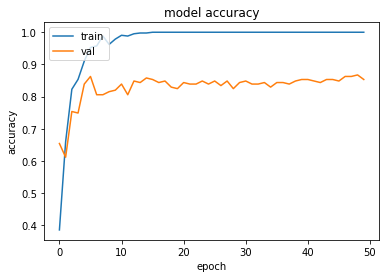

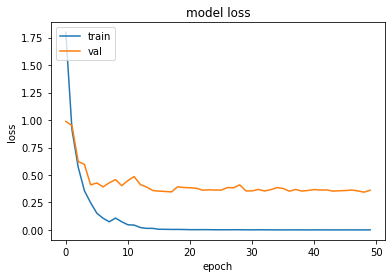

In [9]:
# summarize history for accuracy
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [10]:
score = model.evaluate(test_data, test_label, verbose=0)
print('\n', 'Test accuracy:', score[1])


 Test accuracy: 0.8761904835700989


In [11]:
import pandas as pd

print(test_label)
predictions = model.predict(test_data)
predictions = pd.DataFrame(predictions)
print(predictions.idxmax(axis=1))

[[0. 0. 0. ... 0. 0. 1.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
0      7
1      2
2      7
3      5
4      7
      ..
205    7
206    3
207    7
208    6
209    7
Length: 210, dtype: int64


In [12]:
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

In [13]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

[7 2 7 5 7 6 1 7 1 7 6 3 6 3 5 3 6 5 6 5 5 7 4 3 5 7 3 5 1 6 3 7 7 1 5 1 5
 5 1 2 3 6 1 6 1 6 5 6 6 3 1 5 6 3 4 2 3 2 5 4 7 5 5 0 7 1 3 1 1 2 3 5 3 6
 3 2 6 7 3 6 2 5 7 2 5 0 2 7 0 2 4 7 5 1 7 3 5 0 2 7 5 1 7 7 2 2 2 7 6 6 0
 1 2 7 5 7 2 6 2 2 2 7 6 5 2 5 5 2 3 6 3 6 6 3 5 1 6 1 7 5 7 0 7 7 5 7 5 5
 6 2 7 7 2 5 3 5 7 6 6 0 6 6 7 0 6 3 6 0 1 7 1 3 5 2 6 3 7 5 1 1 5 7 2 2 6
 5 5 1 7 0 7 4 4 7 6 7 1 6 3 6 7 2 0 5 2 7 3 7 6 7]
Confusion matrix, without normalization
[[11  0  0  0  0  0  0  0]
 [ 0 23  0  0  0  7  0  7]
 [ 0  0 27  0  0  0  1  0]
 [ 0  0  0 23  0  1  0  0]
 [ 0  0  0  1  4  4  0  0]
 [ 0  0  0  1  2 26  0  1]
 [ 0  0  1  0  0  0 35  0]
 [ 0  0  0  0  0  0  0 35]]


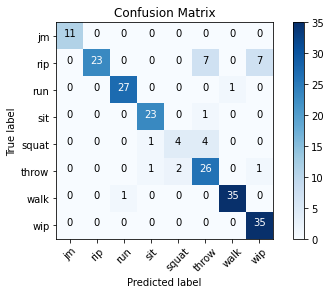

In [14]:
tests = model.predict(test_data)
tests = np.argmax(tests,axis = 1) 
print(tests)
cm_plot_labels = ['jm','rip', 'run','sit','squat','throw','walk','wip']

cm = confusion_matrix(y_true=np.argmax(test_label,axis = 1), y_pred=tests)
plot_confusion_matrix(cm=cm, classes=cm_plot_labels,title='Confusion Matrix')